In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from __future__ import division, print_function, absolute_import

In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

# Using the Model to Make Predictions 

First, let's locate the latest model: It's called ```saved_model.pb```.

In [11]:
from temp_dir import temp_dir
import os
model_dir = os.path.join(temp_dir, "models/export/exporter")
versions = !ls $model_dir
print( "Versions: %s" % versions)
latest_version = max(versions)
latest_model = os.path.join(model_dir, str(latest_version))
!echo $latest_model
!ls $latest_model

Versions: ['1557049341', '1557049342']
/tmp/tmpag65x61e/models/export/exporter/1557049342
saved_model.pb	variables


Create an estimator from that model:

In [12]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpag65x61e/models/export/exporter/1557049342/variables/variables


Use it to predict the humidity for a single record:

In [13]:
sample = {
    'beta1': [[1.234],[1.234]],
    'beta2': [[1.234],[1.234]],
    'weekday': [[5], [6]],
    'hour': [[16], [17]]
}

In [14]:
estimator(sample)

{'output': array([[28.251282],
        [20.235716]], dtype=float32)}

### Verifying prediction quality against the test set

In [15]:
!ls $temp_dir

eval.tfr-00000-of-00001  signature_eval.csv   tftransform_tmp
metadata		 signature_test.csv   training.csv-00000-of-00001
models			 signature_train.csv  training.tfr-00000-of-00001


In [16]:
test_data = pd.read_csv(os.path.join(temp_dir, "signature_test.csv"))
test_data.head()

,beta1,beta2,hour,humidity,weekday
0,0.040457,-1.972043,2,19.536787,2
1,-1.749752,-2.218386,12,17.496738,3
2,-0.091242,-4.100261,19,20.274292,4
3,0.654718,1.116764,18,19.556547,3
4,2.014124,2.151703,7,22.216786,6


In [19]:
test_dict = test_data.drop('humidity', axis=1).to_dict(orient='list')
test_dict = { key: np.reshape(item, [-1,1]) for key, item in test_dict.items()}

In [20]:
predicted = estimator(test_dict)
len(predicted['output'])

20000

In [21]:
test_data['predicted'] = predicted['output'].reshape(-1)

In [22]:
test_data.head()

,beta1,beta2,hour,humidity,weekday,predicted
0,0.040457,-1.972043,2,19.536787,2,19.591858
1,-1.749752,-2.218386,12,17.496738,3,16.209555
2,-0.091242,-4.100261,19,20.274292,4,20.312557
3,0.654718,1.116764,18,19.556547,3,19.402533
4,2.014124,2.151703,7,22.216786,6,21.531185


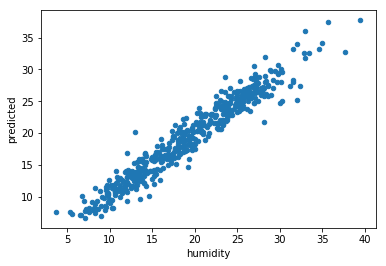

In [23]:
%matplotlib inline
test_data[:500].plot.scatter(x='humidity', y='predicted');

Our prediction strongly correlates with the measured humidity.

In [24]:
test_data['diff'] = test_data['humidity'] - test_data['predicted']

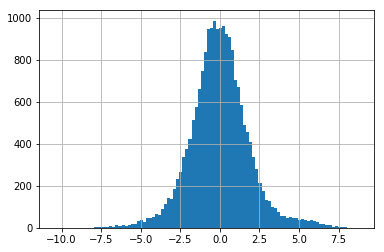

In [25]:
test_data['diff'].hist(bins=100);

And also, the error distribution is truly convincing. The remaining error is almost perfectly Gaussian.

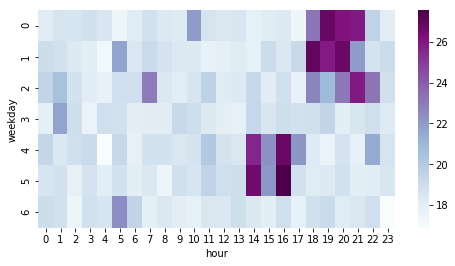

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
sns.heatmap(test_data.pivot_table(
    index='weekday', columns='hour', 
    values='predicted', aggfunc='mean'), cmap='BuPu');

The heatmap of predictions, averaged over $\beta_1$ and $\beta_2$ clearly shows that the model has figured out the anomaly that can be observed Mon-Wed between 18:00 and 21:00 and Fri-Sat between 14:00 and 16:00 hours.